# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

In [2]:
# structure to save accuracy results
allAccuracy = []

In [3]:
savePath = ''

## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [5]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [8]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [9]:
lossDataBaseline, accDataBaseline = trainNN(model)

Epoch 0 - Training loss: 0.7582294314223177
Testing Loss  = 0.3631146590041507
Epoch 1 - Training loss: 0.3057522712384953
Testing Loss  = 0.2822072885598347
Epoch 2 - Training loss: 0.2433159013881403
Testing Loss  = 0.22765891965787122
Epoch 3 - Training loss: 0.2013826867293976
Testing Loss  = 0.21948361327978455
Epoch 4 - Training loss: 0.16725206080004765
Testing Loss  = 0.1699758119952337
Epoch 5 - Training loss: 0.14327997964856876
Testing Loss  = 0.168571503370241
Epoch 6 - Training loss: 0.12474266119549036
Testing Loss  = 0.14327487200024022
Epoch 7 - Training loss: 0.1100948636189027
Testing Loss  = 0.13060433106129146
Epoch 8 - Training loss: 0.09792968523902985
Testing Loss  = 0.1180990329546154
Epoch 9 - Training loss: 0.08887149763348348
Testing Loss  = 0.11586088537102103
Epoch 10 - Training loss: 0.07974576092232256
Testing Loss  = 0.11260437004410537
Epoch 11 - Training loss: 0.07399041974521658
Testing Loss  = 0.10065339524654826
Epoch 12 - Training loss: 0.066601875

In [10]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [11]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

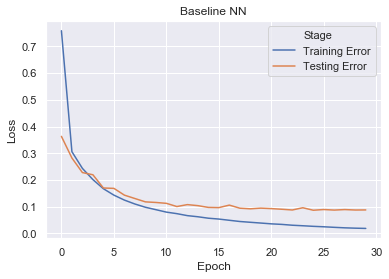

In [12]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

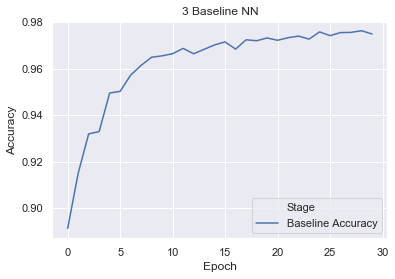

In [13]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [14]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [15]:
correctCount / allCount

0.9767

In [16]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_complex = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [17]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_complex(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [18]:
lossDataComplex, accDataComplex = trainNN(model_complex)

Epoch 0 - Training loss: 0.9544867759813433
Testing Loss  = 0.3868020114245688
Epoch 1 - Training loss: 0.3219491220162729
Testing Loss  = 0.26593964039140444
Epoch 2 - Training loss: 0.23041630481534145
Testing Loss  = 0.20800076799977357
Epoch 3 - Training loss: 0.1791035097778377
Testing Loss  = 0.16366806673479212
Epoch 4 - Training loss: 0.14432781428346397
Testing Loss  = 0.14985327866331788
Epoch 5 - Training loss: 0.122443688988133
Testing Loss  = 0.13399714509108265
Epoch 6 - Training loss: 0.10375474338226802
Testing Loss  = 0.11770491141849643
Epoch 7 - Training loss: 0.0923607102327306
Testing Loss  = 0.11001857131672134
Epoch 8 - Training loss: 0.08238143083113043
Testing Loss  = 0.11061824231770388
Epoch 9 - Training loss: 0.07223458165812599
Testing Loss  = 0.10549061138562527
Epoch 10 - Training loss: 0.06577521227085796
Testing Loss  = 0.09418083659735076
Epoch 11 - Training loss: 0.05823653247749285
Testing Loss  = 0.09003004999712678
Epoch 12 - Training loss: 0.05224

In [19]:
accDataComplex = [[row[0], row[1], 'More nodes and layers Accuracy'] for row in accDataComplex]

In [20]:
lossDataComplex = pd.DataFrame.from_records(lossDataComplex, columns=["Epoch", "Loss", "Stage"])
accDataComplex = pd.DataFrame.from_records(accDataComplex, columns=["Epoch", "Accuracy", "Stage"])

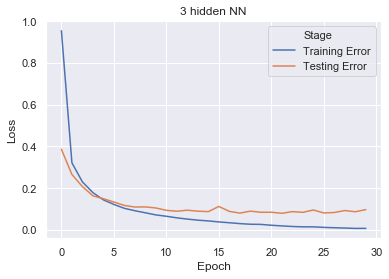

In [21]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataComplex
#     ).set_title('3 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataComplex
    ).set_title('3 hidden NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_3hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 hidden NN')

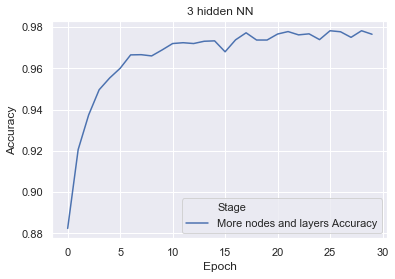

In [22]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataComplex
    ).set_title('3 hidden NN')

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





In [23]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [24]:
correctCount / allCount

0.977

In [25]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_dropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [26]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_dropout(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [27]:
lossDataDropout, accDataDropout = trainNN(model_dropout)

Epoch 0 - Training loss: 1.0093620262678018
Testing Loss  = 0.39871460474600456
Epoch 1 - Training loss: 0.32465761112968633
Testing Loss  = 0.280309872120429
Epoch 2 - Training loss: 0.23651832169698328
Testing Loss  = 0.21075031358250387
Epoch 3 - Training loss: 0.18808528375061576
Testing Loss  = 0.19545185788991346
Epoch 4 - Training loss: 0.1587515063679127
Testing Loss  = 0.1584647116814829
Epoch 5 - Training loss: 0.13420253797003145
Testing Loss  = 0.1440020877345922
Epoch 6 - Training loss: 0.12079378102651185
Testing Loss  = 0.13824313982229702
Epoch 7 - Training loss: 0.11028693184909194
Testing Loss  = 0.12781735368452635
Epoch 8 - Training loss: 0.100784905700256
Testing Loss  = 0.12754236625590523
Epoch 9 - Training loss: 0.09476867217160857
Testing Loss  = 0.11795777611576827
Epoch 10 - Training loss: 0.08403850736065537
Testing Loss  = 0.12019382986079925
Epoch 11 - Training loss: 0.07829336086740656
Testing Loss  = 0.1150119356502583
Epoch 12 - Training loss: 0.0734030

In [28]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]

In [29]:
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

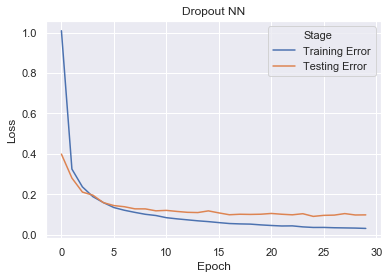

In [30]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

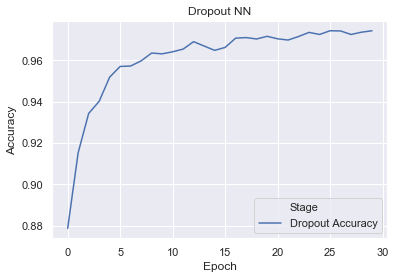

In [31]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [32]:
accData = accDataBaseline.copy()
accData = accData.append(accDataComplex)
accData = accData.append(accDataDropout)

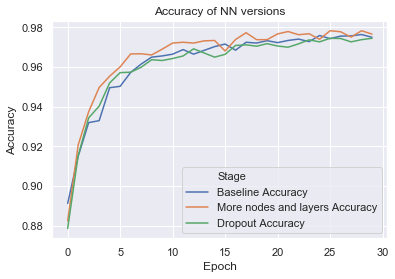

In [33]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_all_accuracy.png", dpi=100)

In [34]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [35]:
correctCount / allCount

0.977

In [36]:
allAccuracy.append(['Neural Network', 'MNIST', correctCount / allCount])

### Credit default dataset

In [148]:
# load dataset
creditDataDf = pd.read_excel(savePath + './data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [149]:
print(sum(creditDataDf['default payment next month']))
print(len(creditDataDf))
print(sum(creditDataDf['default payment next month'])/len(creditDataDf))


6636
30000
0.2212


In [150]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [151]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [152]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [153]:
dfColumns = creditDataDf.columns

In [154]:
# balance the dataset
ros = RandomOverSampler(random_state=37)
creditDataDf, y = ros.fit_resample(creditDataDf, y)

In [155]:
creditDataDf = pd.DataFrame(creditDataDf, columns=dfColumns)

In [156]:
print(sum(y)/len(y))

0.5


In [157]:
# normalize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

In [159]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [160]:
sum(y_train)/len(y_train)

0.5023909045310149

In [161]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))
y_val_tensor = torch.tensor(y_val.values.astype(np.int))

In [162]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [163]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

7477 9346 29905


In [164]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader2 = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [165]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [166]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [167]:
def trainTabNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # optimizer = optim.Adam(model.parameters(), lr=0.01)
    time0 = time()
    epochs = 100
    lossData = []
    accData=[]
    for e in range(epochs):
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [168]:
lossDataBaseline, accDataBaseline = trainTabNN(modelTabBaseline)

Epoch 0 - Training loss: 0.6756760847364736
Testing Loss  = 0.6366128921508789
Testing Accuracy  = 0.6457135214658285
Epoch 1 - Training loss: 0.6125947608906999
Testing Loss  = 0.5965835452079773
Testing Accuracy  = 0.684900361107396
Epoch 2 - Training loss: 0.5935950193267602
Testing Loss  = 0.5831459164619446
Testing Accuracy  = 0.7025545004681022
Epoch 3 - Training loss: 0.5843988829570957
Testing Loss  = 0.5757254958152771
Testing Accuracy  = 0.7053631135482146
Epoch 4 - Training loss: 0.5792282799370269
Testing Loss  = 0.5716055035591125
Testing Accuracy  = 0.7038919352681556
Epoch 5 - Training loss: 0.5761472903765165
Testing Loss  = 0.5688362717628479
Testing Accuracy  = 0.7034907048281396
Epoch 6 - Training loss: 0.5733641013503075
Testing Loss  = 0.5654864311218262
Testing Accuracy  = 0.7064330613882573
Epoch 7 - Training loss: 0.5706086901900096
Testing Loss  = 0.5635504126548767
Testing Accuracy  = 0.7049618831081985
Epoch 8 - Training loss: 0.5689015128673651
Testing Loss 

In [169]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, testloader2, criterion)

In [170]:
correctCount/allCount

0.7282259790284614

In [171]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

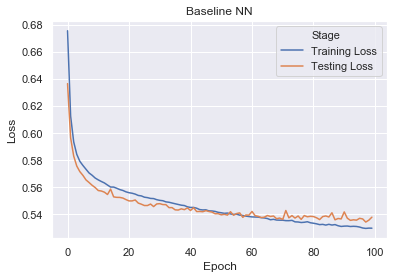

In [172]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Baseline NN')

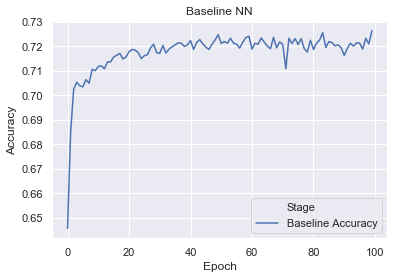

In [173]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

In [174]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2

modelTabLarge = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [175]:
lossDataLarge, accDataLarge = trainTabNN(modelTabLarge)

Epoch 0 - Training loss: 0.693662152840541
Testing Loss  = 0.6930128931999207
Testing Accuracy  = 0.4951183629798047
Epoch 1 - Training loss: 0.6929108817607929
Testing Loss  = 0.6928520798683167
Testing Accuracy  = 0.4951183629798047
Epoch 2 - Training loss: 0.6927885131703483
Testing Loss  = 0.6929002404212952
Testing Accuracy  = 0.4951183629798047
Epoch 3 - Training loss: 0.6925524255404105
Testing Loss  = 0.6923089623451233
Testing Accuracy  = 0.5887387989835495
Epoch 4 - Training loss: 0.6921253197977686
Testing Loss  = 0.6919935941696167
Testing Accuracy  = 0.4951183629798047
Epoch 5 - Training loss: 0.6915044882613369
Testing Loss  = 0.6911749243736267
Testing Accuracy  = 0.4951183629798047
Epoch 6 - Training loss: 0.689955463521501
Testing Loss  = 0.6883351802825928
Testing Accuracy  = 0.5587802594623512
Epoch 7 - Training loss: 0.6843631509532276
Testing Loss  = 0.6768285632133484
Testing Accuracy  = 0.6434398823057376
Epoch 8 - Training loss: 0.6501841676922945
Testing Loss  

In [176]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [177]:
correctCount/allCount

0.7246950567087524

In [178]:
accDataLarge = [[row[0], row[1], '5 hidden Accuracy'] for row in accDataLarge]
lossDataLarge = pd.DataFrame.from_records(lossDataLarge, columns=["Epoch", "Loss", "Stage"])
accDataLarge = pd.DataFrame.from_records(accDataLarge, columns=["Epoch", "Accuracy", "Stage"])

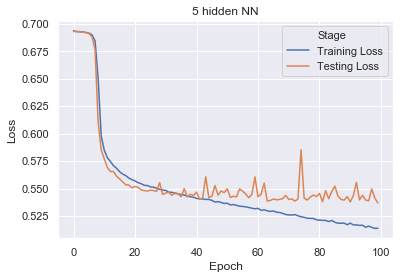

In [179]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataLarge
    # ).set_title('5 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataLarge
    ).set_title('5 hidden NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_5hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '5 hidden NN')

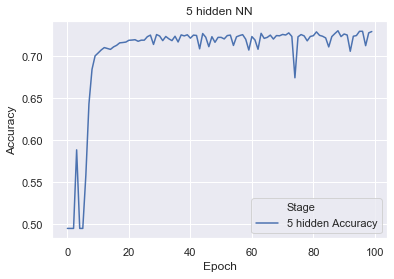

In [180]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataLarge
    ).set_title('5 hidden NN')

In [181]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2
drop_out = 0.2

modelTabDropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [182]:
lossDataDropout, accDataDropout = trainTabNN(modelTabDropout)

Epoch 0 - Training loss: 0.6936810527347091
Testing Loss  = 0.6924472451210022
Testing Accuracy  = 0.5052828674602113
Epoch 1 - Training loss: 0.6924037283811814
Testing Loss  = 0.6921276450157166
Testing Accuracy  = 0.5249431590209978
Epoch 2 - Training loss: 0.6917727804846234
Testing Loss  = 0.6910460591316223
Testing Accuracy  = 0.5742945031429718
Epoch 3 - Training loss: 0.6901382406552633
Testing Loss  = 0.6884083151817322
Testing Accuracy  = 0.5676073291427043
Epoch 4 - Training loss: 0.6839226945343181
Testing Loss  = 0.6749092936515808
Testing Accuracy  = 0.6277918951451117
Epoch 5 - Training loss: 0.6567680679070644
Testing Loss  = 0.6312379240989685
Testing Accuracy  = 0.66350140430654
Epoch 6 - Training loss: 0.6145640188175389
Testing Loss  = 0.6045030355453491
Testing Accuracy  = 0.6873077437474923
Epoch 7 - Training loss: 0.6022866037156847
Testing Loss  = 0.5946609377861023
Testing Accuracy  = 0.6881102046275244
Epoch 8 - Training loss: 0.5933670423224441
Testing Loss  

In [183]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabDropout, testloader2, criterion)

In [184]:
correctCount/allCount

0.7141022897496255

In [185]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

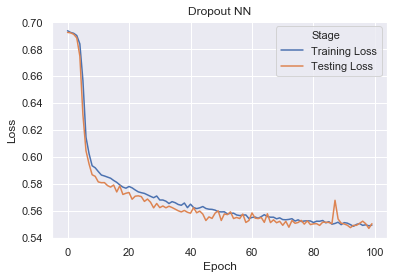

In [186]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

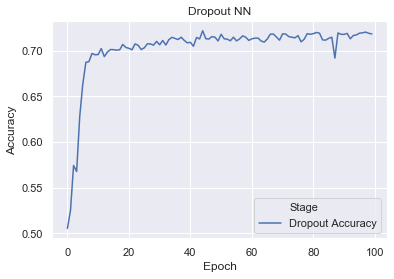

In [187]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [188]:
accData = accDataBaseline.copy()
accData = accData.append(accDataLarge)
accData = accData.append(accDataDropout)

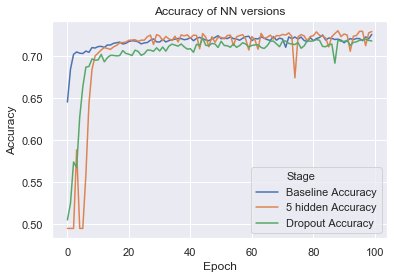

In [189]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_all_accuracy.png", dpi=100)

In [190]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [191]:
allAccuracy.append(['Neural Network', 'Credit', correctCount / allCount])

,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,Neural Network,NaN,NaN,NaN
1,Credit,NaN,NaN,NaN
2,0.724695,NaN,NaN,NaN


## Decision tree

### MNIST dataset

In [192]:
trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)

In [193]:
X_train_MNIST = trainset.data.numpy()
X_test_MNIST = testset.data.numpy()

In [194]:
y_train_MNIST = trainset.targets.numpy()
y_test_MNIST = testset.targets.numpy()

In [195]:
np.bincount(y_train_MNIST) + np.bincount(y_test_MNIST)

array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958])

In [196]:
print(X_train_MNIST.shape)
print(y_train_MNIST.shape)

(60000, 28, 28)
(60000,)


In [197]:
X_train_MNIST_reshaped = X_train_MNIST.reshape((60000, 784))
X_test_MNIST_reshaped = X_test_MNIST.reshape((10000, 784))

In [198]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
gridSearchTree.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 21.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [199]:
gridSearchTree.best_params_

{'max_depth': 15, 'min_samples_leaf': 5}

In [200]:
preds = gridSearchTree.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

0.8825


In [201]:
allAccuracy.append(['Decision Tree', 'MNIST', accuracy_score(preds, y_test_MNIST)])

,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,Decision Tree,NaN,NaN,NaN
1,MNIST,NaN,NaN,NaN
2,0.8825,NaN,NaN,NaN


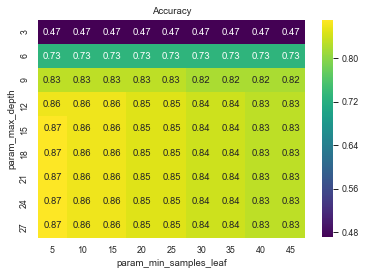

In [202]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_accuracy.png", dpi=100)

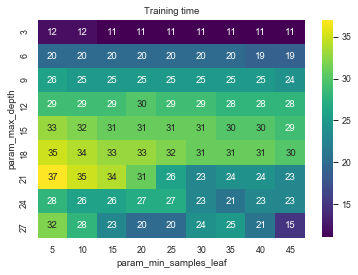

In [203]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 0)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_train-time.png", dpi=100)

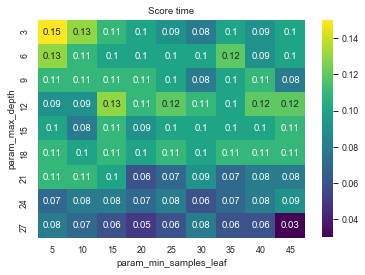

In [204]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_score-time.png", dpi=100)

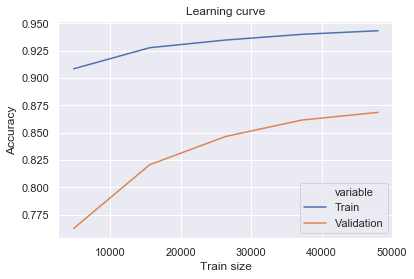

In [205]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')
sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_learning-curve.png", dpi=100)

### Credit default dataset

In [206]:
np.bincount(y_train) + np.bincount(y_test) + np.bincount(y_val)

array([23364, 23364])

In [207]:
# concatenate dfs
X_train = pd.concat([X_train,X_val], axis=0)
y_train = np.concatenate([y_train,y_val], axis=0)
print(X_train.shape)
print(y_train.shape)

(37382, 30)
(37382,)


In [208]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=2, scoring='accuracy'
    )
gridSearchTree.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   29.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [209]:
preds = gridSearchTree.predict(X_test)
probs = gridSearchTree.predict_proba(X_test)
print(accuracy_score(preds, y_test))

0.8019473571581425


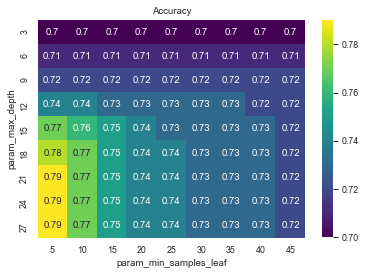

In [210]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_accuracy.png", dpi=100)

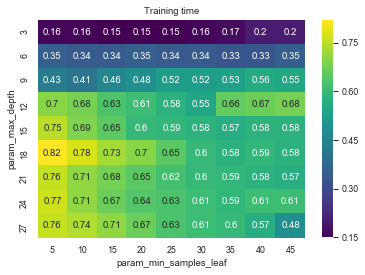

In [211]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_training-time.png", dpi=100)

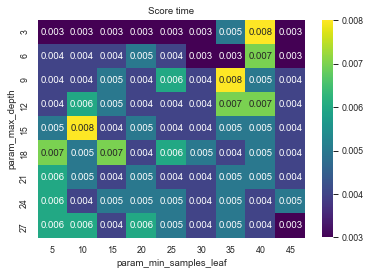

In [212]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_score-time.png", dpi=100)

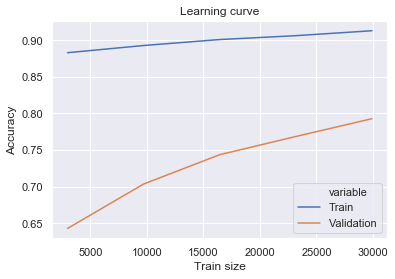

In [213]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_learning-curve.png", dpi=100)

In [214]:
preds = gridSearchTree.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Decision Tree', 'Credit', accuracy_score(preds, y_test)])

0.8019473571581425


,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,Decision Tree,NaN,NaN,NaN
1,Credit,NaN,NaN,NaN
2,0.801947,NaN,NaN,NaN


In [215]:
print(allAccuracy)

Algorithm Dataset  Accuracy
0  Neural Network   MNIST     0.977
1  Neural Network  Credit     0.977


## Boosting

### MNIST

In [216]:
param_grid = {'max_depth': np.arange(5, 30, 5), 'n_estimators': np.arange(10, 50, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=4), param_grid, n_jobs=4, verbose=3, scoring='accuracy', cv=2
    )
gridSearchBoosting.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 33.4min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 61.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'n_estimators': array([10, 20, 30,

In [217]:
gridSearchBoosting.best_params_

{'max_depth': 10, 'n_estimators': 40}

In [218]:
preds = gridSearchBoosting.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['Boosting', 'MNIST', accuracy_score(preds, y_test_MNIST)])

0.973


,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,Boosting,NaN,NaN,NaN
1,MNIST,NaN,NaN,NaN
2,0.973,NaN,NaN,NaN


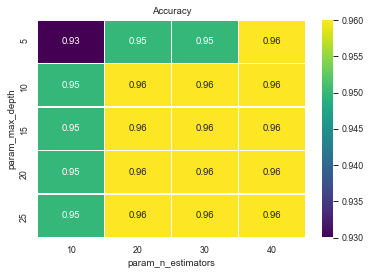

In [219]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_accuracy.png", dpi=100)

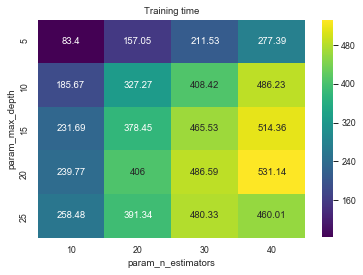

In [220]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_train-time", dpi=100)

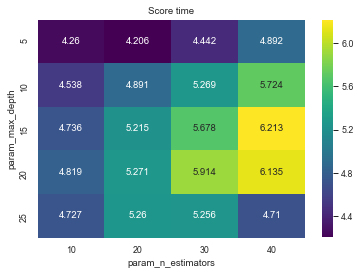

In [221]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_score-time.png", dpi=100)

In [222]:
bestModel = xgb.XGBClassifier(**gridSearchBoosting.best_params_, nthreads=4)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=4,
                                            verbose=5
                                            )

[learning_curve] Training set sizes: [ 3000  9750 16500 23250 30000]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of  10 | elapsed:  4.8min remaining: 19.4min
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed: 10.9min remaining: 10.9min
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed: 16.2min remaining:  4.1min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 25.0min finished


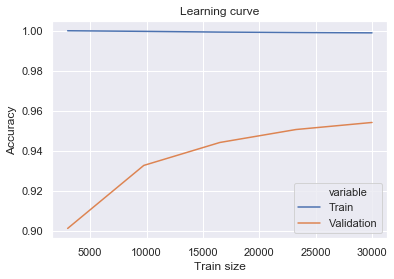

In [223]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_learning-curve.png", dpi=100)

### Credit default

In [224]:
param_grid = {'max_depth': np.arange(5, 30, 5), 'n_estimators': np.arange(10, 50, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=4), param_grid, n_jobs=4, verbose=3, scoring='accuracy', cv=2
    )
gridSearchBoosting.fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   28.4s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'n_estimators': array([10, 20, 30,

In [225]:
preds = gridSearchBoosting.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Boosting', 'Credit', accuracy_score(preds, y_test)])
print(gridSearchBoosting.best_params_)

0.9238176760111277
{'max_depth': 25, 'n_estimators': 40}


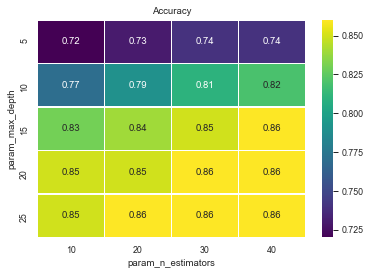

In [226]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_accuracy.png", dpi=100)

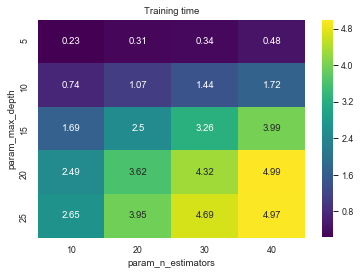

In [227]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_training-time.png", dpi=100)

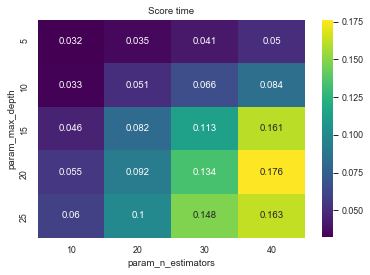

In [228]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_score-time.png", dpi=100)

In [229]:
bestModel = xgb.XGBClassifier(**gridSearchBoosting.best_params_, nthreads=4)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=4,
                                            verbose=5
                                            )

[learning_curve] Training set sizes: [ 1869  6074 10280 14485 18691]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of  10 | elapsed:    2.3s remaining:    9.3s
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed:    8.9s remaining:    2.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   13.7s finished


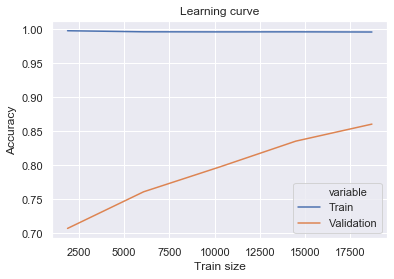

In [230]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_learning-curve.png", dpi=100)

In [231]:
print(allAccuracy)

Algorithm Dataset  Accuracy
0  Neural Network   MNIST     0.977
1  Neural Network  Credit     0.977


## KNN

### MNIST

In [232]:
param_grid = {'n_neighbors': np.arange(5, 25, 5), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
kNN.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = kNN.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['KNN', 'MNIST', accuracy_score(preds, y_test_MNIST)])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed: 107.6min remaining: 35.9min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 107.7min finished
0.9691


,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,KNN,NaN,NaN,NaN
1,MNIST,NaN,NaN,NaN
2,0.9691,NaN,NaN,NaN


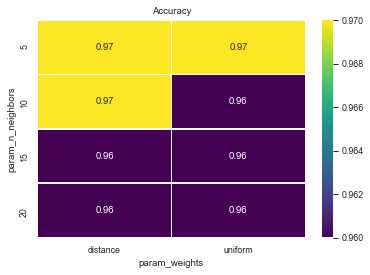

In [233]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_accuracy.png", dpi=100)

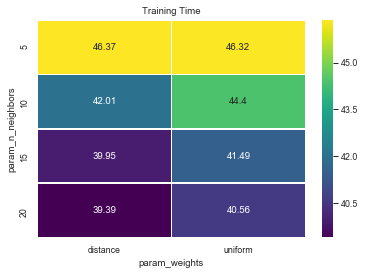

In [234]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_training-time.png", dpi=100)

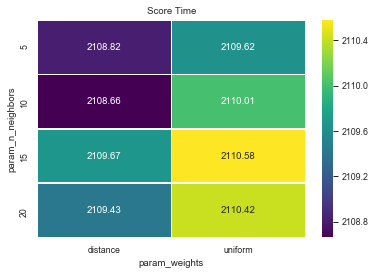

In [235]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_score-time.png", dpi=100)

In [236]:
allAccuracy

,Algorithm,Dataset,Accuracy
0,Neural Network,MNIST,0.977
1,Neural Network,Credit,0.977


[learning_curve] Training set sizes: [ 3000  9750 16500 23250 30000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  4.0min remaining: 15.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 31.3min remaining: 31.3min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 42.8min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 52.3min finished


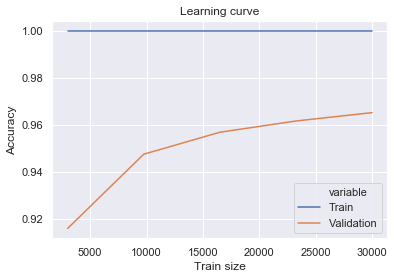

In [237]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_learning-curve.png", dpi=100)

### Credit default

In [238]:
param_grid = {'n_neighbors': np.arange(5, 25, 5), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
kNN.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  2.2min remaining:   43.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 5, 10, 15, 20]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [239]:
preds = kNN.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['KNN', 'Credit', accuracy_score(preds, y_test)])

0.849882302589343


,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,KNN,NaN,NaN,NaN
1,Credit,NaN,NaN,NaN
2,0.849882,NaN,NaN,NaN


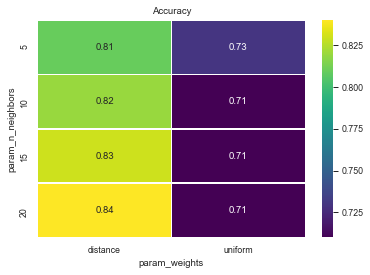

In [240]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_accuracy.png", dpi=100)

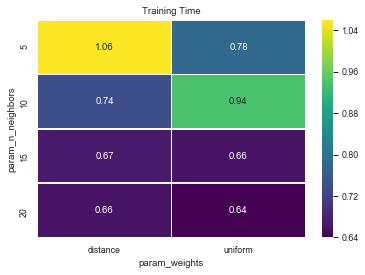

In [241]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_training-time.png", dpi=100)

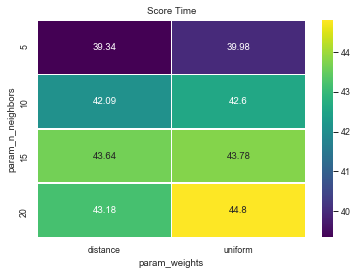

In [242]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 1869  6074 10280 14485 18691]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   14.0s remaining:   32.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   50.3s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


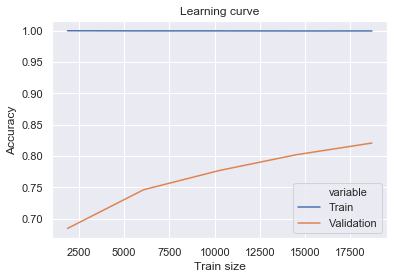

In [243]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=-1,
                                            verbose=3
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_learning-curve.png", dpi=100)

## SVM

### MNIST

In [244]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': [10, 500, 2000]}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
SVM.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = SVM.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['SVM', 'MNIST', accuracy_score(preds, y_test_MNIST)])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed: 29.8min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 35.2min finished
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
0.9797


,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,SVM,NaN,NaN,NaN
1,MNIST,NaN,NaN,NaN
2,0.9797,NaN,NaN,NaN


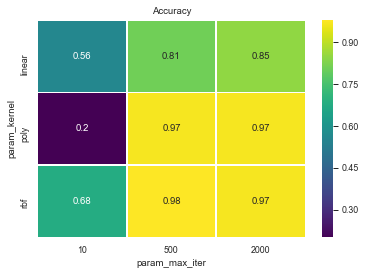

In [245]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_accuracy.png", dpi=100)

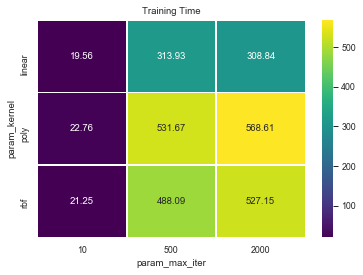

In [246]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_training-time.png", dpi=100)

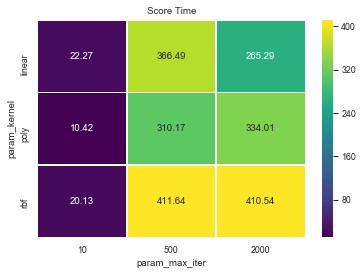

In [247]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 4000 13000 22000 31000 40000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  7.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 14.3min remaining: 12.5min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 24.3min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 30.0min finished


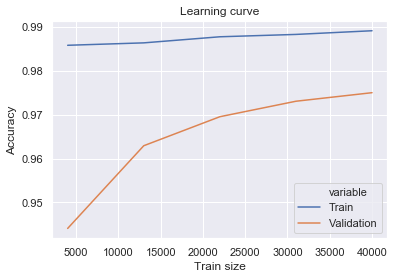

In [248]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=3,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_learning-curve.png", dpi=100)

### Credit default

In [249]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': [10, 500, 2000, 10000, 30000]}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
SVM.fit(X_train, y_train)

preds = SVM.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['SVM', 'Credit', accuracy_score(preds, y_test)])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.5min finished
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
0.6625294243526643


,0,Accuracy,Algorithm,Dataset
0,NaN,0.977,Neural Network,MNIST
1,NaN,0.977,Neural Network,Credit
0,SVM,NaN,NaN,NaN
1,Credit,NaN,NaN,NaN
2,0.662529,NaN,NaN,NaN


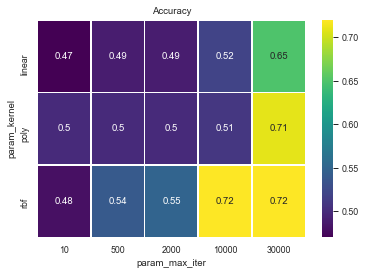

In [250]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_accuracy.png", dpi=100)

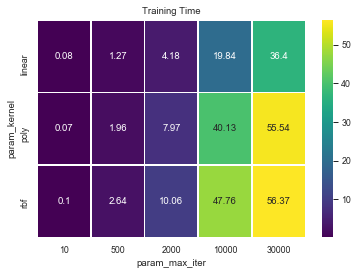

In [251]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_training-time.png", dpi=100)

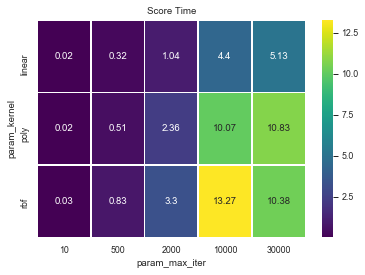

In [252]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 2492  8099 13706 19313 24921]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   13.2s remaining:   36.3s
/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   32.2s remaining:   28.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.2min remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished


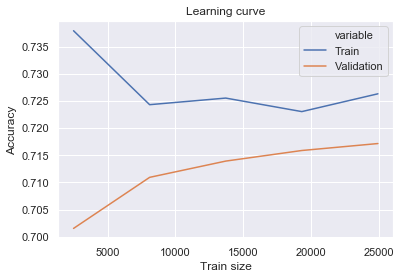

In [253]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=3,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_learning-curve.png", dpi=100)

In [254]:
print(allAccuracy)

Algorithm Dataset  Accuracy
0  Neural Network   MNIST     0.977
1  Neural Network  Credit     0.977


In [255]:
# allAccuracy = [
#     ['Neural Network', 'MNIST', 0.9806], 
#     ['Neural Network', 'Credit', 0.7261930237534774], 
#     ['Decision Tree', 'MNIST', 0.8836], 
#     ['Decision Tree', 'Credit', 0.8031243312647122],
#     ['Boosting', 'MNIST', 0.973], 
#     ['Boosting', 'Credit', 0.9033811256152364],
#     ['KNN', 'MNIST', 0.9691], 
#     ['KNN', 'Credit', 0.8400385191525787], 
#     ['SVM', 'MNIST', 0.979], 
#     ['SVM', 'Credit', 0.66252]
#     ]

In [256]:
allAccuracy = pd.DataFrame(
    allAccuracy,
    columns=['Algorithm', 'Dataset', 'Accuracy']
)

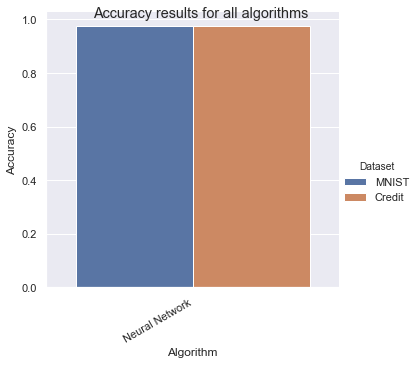

In [257]:
sns.set(
    style="darkgrid"
    )

sns_plot = sns.catplot(
    x="Algorithm", y="Accuracy",
    hue="Dataset",
    data=allAccuracy,
    kind='bar'
    )
    
sns_plot.fig.suptitle('Accuracy results for all algorithms')
# sns_plot.ax.set_xticklabels(sns_plot.ax.get_xticklabels(), rotation=90, ha="right")
sns_plot.fig.autofmt_xdate()
    
sns_plot.fig.savefig(savePath + "all_results.png", dpi=100)

# END